# Spark MLLib

- [Official documentation](http://spark.apache.org/docs/latest/ml-guide.html)
- [PySpark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html)

The MLLib library has two packages - `pyspark.mllib` which provides an RDD interface, and `pyspark.ml` which provides a DataFrame interface. we will focus only on the high-level interface.

Topics:

- Preparing a DataFrame for ML
- Generating simple statistics
- Splitting data
- Preprocessing
    - Feature extraction
    - Imputation
    - Transforms
- Unsupervised learning
- Supervised learning
    - Hyperparameter optimization
    - Using R formula
    - Evaluation
- Using pipelines

### Set up Spark and Spark SQL contexts

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = (
    SparkSession.builder 
    .master("local") 
    .appName("BIOS-823") 
    .config("spark.executor.cores", 4) 
    .getOrCreate()    
)

## Preparing a DataFrame for ML

Spark provides dense and sparse vectors and matrices mainly as data structures for ML, so even though they live in the `ml.linalg` module, the ability to manipulate them is very limited.

In [3]:
import numpy as np

In [4]:
from pyspark.ml.linalg import Vectors

### Vectors

In [5]:
v1 = Vectors.dense(range(1,11))
v2 = Vectors.dense(range(0, 10))

In [6]:
v1

DenseVector([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

In [7]:
v2

DenseVector([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

#### To numpy array

In [8]:
v1.array

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

#### Simple vector operations

In [9]:
v1.norm(p=1)

55.0

In [10]:
v1.sum()

55.0

In [11]:
v1.norm(p=2)

19.621416870348583

In [12]:
np.sqrt((v1*v1).sum())

19.621416870348583

In [13]:
v1.squared_distance(v2)

10.0

In [14]:
((v1 - v2).array**2).sum()

10.0

In [15]:
v1.dot(v2)

330.0

### Manual construction of an ML DaataFrame

ML operations generally require a DataFrame with columns corresponding to a a label and features represented as a Vector.

In [16]:
data =[
    (0.0, Vectors.dense([1,2,3])), 
    (1.0, Vectors.dense([2,3,4])),
    (0.0, Vectors.dense([3,4,5])),
    (1.0, Vectors.dense([2,2,2]))
]

df = spark.createDataFrame(data, ['label', 'features'])

In [17]:
df.show()

+-----+-------------+
|label|     features|
+-----+-------------+
|  0.0|[1.0,2.0,3.0]|
|  1.0|[2.0,3.0,4.0]|
|  0.0|[3.0,4.0,5.0]|
|  1.0|[2.0,2.0,2.0]|
+-----+-------------+



#### Converting to a standard DataFrame

In [18]:
from pyspark.ml.functions import vector_to_array

In [19]:
from pyspark.sql.functions import col

In [20]:
df.select('label', vector_to_array('features')).show()

+-----+---------------+
|label|  UDF(features)|
+-----+---------------+
|  0.0|[1.0, 2.0, 3.0]|
|  1.0|[2.0, 3.0, 4.0]|
|  0.0|[3.0, 4.0, 5.0]|
|  1.0|[2.0, 2.0, 2.0]|
+-----+---------------+



In [21]:
df.withColumn("xs", vector_to_array("features")).show()

+-----+-------------+---------------+
|label|     features|             xs|
+-----+-------------+---------------+
|  0.0|[1.0,2.0,3.0]|[1.0, 2.0, 3.0]|
|  1.0|[2.0,3.0,4.0]|[2.0, 3.0, 4.0]|
|  0.0|[3.0,4.0,5.0]|[3.0, 4.0, 5.0]|
|  1.0|[2.0,2.0,2.0]|[2.0, 2.0, 2.0]|
+-----+-------------+---------------+



In [22]:
df.withColumn("xs", vector_to_array("features")).dtypes

[('label', 'double'), ('features', 'vector'), ('xs', 'array<double>')]

In [23]:
(
    df.
    withColumn("xs", vector_to_array("features")).
    select(["label"] + [col("xs")[i] for i in range(3)])
).show()

+-----+-----+-----+-----+
|label|xs[0]|xs[1]|xs[2]|
+-----+-----+-----+-----+
|  0.0|  1.0|  2.0|  3.0|
|  1.0|  2.0|  3.0|  4.0|
|  0.0|  3.0|  4.0|  5.0|
|  1.0|  2.0|  2.0|  2.0|
+-----+-----+-----+-----+



### Using VectorAssembler

In [24]:
from pyspark.ml.feature import VectorAssembler

In [25]:
import pandas as pd

In [26]:
url = 'https://bit.ly/3eoBK6t'
pdf = pd.read_csv(url)

In [27]:
pdf.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [28]:
iris = spark.createDataFrame(pdf)

In [29]:
iris.show(3)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 3 rows



In [30]:
iris.columns[:-1]

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [31]:
assembler = VectorAssembler(
    inputCols=iris.columns[:-1],
    outputCol='raw_features')
df = assembler.transform(iris)

In [32]:
df.show(3)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|     raw_features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 3 rows



### Generating simple statistics

In [33]:
import pyspark.ml.stat as stat 

In [34]:
df.select(stat.Summarizer.mean(col('raw_features'))).show()

+--------------------+
|  mean(raw_features)|
+--------------------+
|[5.84333333333333...|
+--------------------+



In [35]:
(
    df.select(
        stat.Summarizer.metrics('std', 'min', 'max', 'mean').
        summary(col('raw_features'))).
    show(truncate=False)
)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|aggregate_metrics(raw_features, 1.0)                                                                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[0.8280661279778628,0.43359431136217363,1.7644204199522624,0.7631607417008414], [4.3,2.0,1.0,0.1], [7.9,4.4,6.9,2.5], [5.843333333333335,3.0540000000000003,3.758666666666667,1.1986666666666668]]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



### Split data

In [36]:
train_data, test_data = df.randomSplit(weights=[2.,1.], seed=0)

In [37]:
train_data.count(), test_data.count()

(98, 52)

In [38]:
train_data.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|   species|     raw_features|
+------------+-----------+------------+-----------+----------+-----------------+
|         5.7|        4.4|         1.5|        0.4|    setosa|[5.7,4.4,1.5,0.4]|
|         5.4|        3.4|         1.5|        0.4|    setosa|[5.4,3.4,1.5,0.4]|
|         5.9|        3.0|         4.2|        1.5|versicolor|[5.9,3.0,4.2,1.5]|
|         6.1|        2.8|         4.0|        1.3|versicolor|[6.1,2.8,4.0,1.3]|
|         6.1|        2.9|         4.7|        1.4|versicolor|[6.1,2.9,4.7,1.4]|
|         6.2|        2.2|         4.5|        1.5|versicolor|[6.2,2.2,4.5,1.5]|
|         6.7|        3.1|         4.4|        1.4|versicolor|[6.7,3.1,4.4,1.4]|
|         6.7|        3.0|         5.0|        1.7|versicolor|[6.7,3.0,5.0,1.7]|
|         5.7|        2.8|         4.1|        1.3|versicolor|[5.7,2.8,4.1,1.3]|
|         6.7|        3.3|  

In [39]:
test_data.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|   species|     raw_features|
+------------+-----------+------------+-----------+----------+-----------------+
|         5.0|        3.0|         1.6|        0.2|    setosa|[5.0,3.0,1.6,0.2]|
|         5.0|        3.5|         1.3|        0.3|    setosa|[5.0,3.5,1.3,0.3]|
|         5.0|        3.5|         1.6|        0.6|    setosa|[5.0,3.5,1.6,0.6]|
|         4.9|        2.4|         3.3|        1.0|versicolor|[4.9,2.4,3.3,1.0]|
|         5.6|        3.0|         4.1|        1.3|versicolor|[5.6,3.0,4.1,1.3]|
|         5.7|        2.5|         5.0|        2.0| virginica|[5.7,2.5,5.0,2.0]|
+------------+-----------+------------+-----------+----------+-----------------+



In [40]:
train_data = train_data.persist()

## Processing data

### Encoding categorical features

In [41]:
from pyspark.ml.feature import StringIndexer

In [42]:
indexer = StringIndexer(inputCol='species', outputCol='label')

In [43]:
indexer = indexer.fit(train_data)

In [44]:
train_df = indexer.transform(train_data)
test_df = indexer.transform(test_data)

In [45]:
train_df.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|   species|     raw_features|label|
+------------+-----------+------------+-----------+----------+-----------------+-----+
|         5.0|        2.0|         3.5|        1.0|versicolor|[5.0,2.0,3.5,1.0]|  1.0|
|         6.1|        2.9|         4.7|        1.4|versicolor|[6.1,2.9,4.7,1.4]|  1.0|
|         5.5|        2.4|         3.7|        1.0|versicolor|[5.5,2.4,3.7,1.0]|  1.0|
|         5.4|        3.0|         4.5|        1.5|versicolor|[5.4,3.0,4.5,1.5]|  1.0|
|         7.3|        2.9|         6.3|        1.8| virginica|[7.3,2.9,6.3,1.8]|  2.0|
|         5.8|        2.8|         5.1|        2.4| virginica|[5.8,2.8,5.1,2.4]|  2.0|
|         6.0|        2.2|         5.0|        1.5| virginica|[6.0,2.2,5.0,1.5]|  2.0|
|         7.9|        3.8|         6.4|        2.0| virginica|[7.9,3.8,6.4,2.0]|  2.0|
|         5.9|        3.0|         5.1|    

### Scaling

In [46]:
from pyspark.ml.feature import StandardScaler

In [47]:
scaler = StandardScaler(withMean=True,
                        withStd=True,
                        inputCol='raw_features',
                        outputCol='features')

In [48]:
scaler = scaler.fit(train_df)

In [49]:
train_df_scaled = scaler.transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [50]:
train_df_scaled.select('features', 'features').show(5, truncate=False)

+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|features                                                                         |features                                                                         |
+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|[-1.5213158492369616,0.00692241917037384,-1.2132855899947563,-1.22045281288949]  |[-1.5213158492369616,0.00692241917037384,-1.2132855899947563,-1.22045281288949]  |
|[-1.5213158492369616,0.6853194978669278,-1.2714283713245784,-1.0882932817699649] |[-1.5213158492369616,0.6853194978669278,-1.2714283713245784,-1.0882932817699649] |
|[-1.390075573510533,0.23305477873589214,-1.3295711526544005,-1.22045281288949]   |[-1.390075573510533,0.23305477873589214,-1.3295711526544005,-1.22045281288949]   |
|[-1

## Unsupervised learning

### Dimension reduction

In [51]:
from pyspark.ml.feature import PCA

In [52]:
pca = PCA(k=2, inputCol='features', outputCol='pc').fit(train_df_scaled)

In [53]:
train_df_scaled = pca.transform(train_df_scaled)

In [54]:
train_df_scaled.select('pc').show(5, truncate=False)

+---------------------------------------+
|pc                                     |
+---------------------------------------+
|[2.1719561815281763,0.7342240484007614]|
|[2.325768434882429,0.11499107410380782]|
|[2.2379887825335114,0.4753763677684271]|
|[1.9410238356438352,0.7700780683206436]|
|[2.046967548842131,0.5739261085291687] |
+---------------------------------------+
only showing top 5 rows



In [55]:
import matplotlib.pyplot as plt

In [56]:
pdf = (
    train_df_scaled.select('label', 'pc').
    withColumn("pc", vector_to_array("pc")).
    select(["label"] + [col("pc")[i] for i in range(2)])
).toPandas()

In [57]:
pdf.head(3)

,label,pc[0],pc[1]
0,0.0,2.171956,0.734224
1,0.0,2.325768,0.114991
2,0.0,2.237989,0.475376


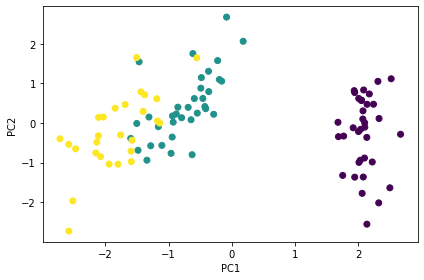

In [58]:
plt.scatter(pdf.iloc[:, 1], pdf.iloc[:, 2], c=pdf.iloc[:, 0])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

### Clustering

In [59]:
from pyspark.ml.clustering import GaussianMixture

In [60]:
gmm = GaussianMixture(
    featuresCol='features',
    k=3, 
    seed=0)

In [61]:
gmm = gmm.fit(train_df_scaled)

In [62]:
gmm.gaussiansDF.toPandas()

,mean,cov
0,"[-0.9380257346418973, 0.8046671327476245, -1.2...","DenseMatrix([[0.2166823 , 0.29970786, 0.013235..."
1,"[0.005938775919945028, -0.5221004264901147, 0....","DenseMatrix([[ 0.10356088, -0.0849359 , 0.056..."
2,"[0.6061006081018865, -0.4609677242002641, 0.72...","DenseMatrix([[0.65443637, 0.40398667, 0.255851..."


In [63]:
train_df_scaled = gmm.transform(train_df_scaled)

In [64]:
train_df_scaled.select('features', 'label', 'probability', 'prediction').sample(0.1).show()

+--------------------+-----+--------------------+----------+
|            features|label|         probability|prediction|
+--------------------+-----+--------------------+----------+
|[-0.9963547463312...|  0.0|[0.99999999999615...|         0|
|[-0.0776728162462...|  0.0|[0.99999999999999...|         0|
|[-0.9963547463312...|  0.0|[0.99999999995404...|         0|
|[0.44728828665945...|  1.0|[1.17415562661057...|         2|
+--------------------+-----+--------------------+----------+



## Supervised Learning

In [65]:
train_df_scaled = train_df_scaled.select('features', 'label')

In [66]:
test_df_scaled = test_df_scaled.select('features', 'label')

In [67]:
from pyspark.ml.classification import RandomForestClassifier

In [68]:
rf = RandomForestClassifier(
    numTrees=10,
    maxDepth=3,
    seed=0
)

In [69]:
rf = rf.fit(train_df_scaled)

In [70]:
test_df_scaled = rf.transform(test_df_scaled)

In [71]:
test_df_scaled.sample(0.1).show()

+--------------------+-----+--------------+-------------+----------+
|            features|label| rawPrediction|  probability|prediction|
+--------------------+-----+--------------+-------------+----------+
|[-0.8651144706048...|  0.0|[10.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[-1.5213158492369...|  0.0|[10.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
+--------------------+-----+--------------+-------------+----------+



### Model evaluation

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [73]:
evaluator = MulticlassClassificationEvaluator()

#### Default is f1 score

In [74]:
evaluator.evaluate(test_df_scaled)

0.9618662587412588

In [75]:
evaluator = evaluator.setMetricName('accuracy')

In [76]:
evaluator.evaluate(test_df_scaled)

0.9615384615384616

### Pipelines

We can assemble pipeline for convenience and reproducibility. This is very similar to what you would do with `sklearn`, except that MLLib allows you to handle massive datasets by distributing the analysis to multiple computers.

We will put all the preceding steps into the pipeline, and also add hyperparameter optimization via cross-validation.

In [77]:
from pyspark.ml import Pipeline

In [78]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [79]:
assembler = VectorAssembler(
    inputCols=iris.columns[:-1],
    outputCol='raw_features'
)
scaler = StandardScaler(
    withMean=True, 
    withStd=True, 
    inputCol='raw_features', 
    outputCol='features'
)
indexer = StringIndexer(
    inputCol="species", 
    outputCol="label"
)
rf = RandomForestClassifier()
params = (
    ParamGridBuilder().
    addGrid(rf.numTrees, [5,10,25]).
    addGrid(rf.maxDepth, [3,4,5]).
    build()
)
evaluator = MulticlassClassificationEvaluator(
    metricName='accuracy'
)
cv = CrossValidator(
    estimator=rf,
    evaluator=evaluator,
    estimatorParamMaps=params,
    numFolds=3,
    seed=0
).setParallelism(4)

In [80]:
pipeline = Pipeline(
    stages=[assembler, scaler, indexer, cv]
)

In [81]:
train_iris, test_iris = iris.randomSplit([2.0, 1.0], seed=0)

In [82]:
model = pipeline.fit(train_iris)

#### Accessing pipeline stages

In [83]:
model.stages

[VectorAssembler_52c89be6b9a2,
 StandardScalerModel: uid=StandardScaler_34c928f49d0f, numFeatures=4, withMean=true, withStd=true,
 StringIndexerModel: uid=StringIndexer_321a822eab54, handleInvalid=error,
 CrossValidatorModel_d21b0a235e7d]

In [84]:
df_cv = pd.DataFrame(list(zip(model.stages[3].getEstimatorParamMaps(), model.stages[3].avgMetrics)))
df_cv[['numTrees', 'maxDepth']] = df_cv[0].apply(lambda x: pd.Series(list(x.values())))
df_cv = df_cv.drop(0, axis=1)
df_cv = df_cv.iloc[:, [1,2,0]]
df_cv.columns = df_cv.columns[:2].tolist() + ['accuracy']
df_cv.sort_values('accuracy', ascending=False)

,numTrees,maxDepth,accuracy
6,25,3,0.958970
7,25,4,0.958970
8,25,5,0.958970
5,10,5,0.948217
2,5,5,0.941426
0,5,3,0.940685
3,10,3,0.936723
4,10,4,0.936723
1,5,4,0.929932


#### Evaluate model on test data

In [85]:
prediction = model.transform(test_iris)

In [86]:
evaluator.evaluate(prediction)

0.9807692307692307

## Using Spark for non-MLLib models

We will run a grid search on a Spark cluster using `scikit-learn`

In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import parallel_backend
from joblibspark import register_spark

In [88]:
url = 'https://bit.ly/3eoBK6t'
iris = pd.read_csv(url)

In [89]:
X = iris.iloc[:, :-1]
y = iris.species.astype('category').cat.codes

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [91]:
svc = SVC(random_state=0)
params = dict(
    C = [0.1, 1, 10],
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
)
cv = GridSearchCV(svc, params, cv=3)

In [93]:
register_spark()

In [94]:
with parallel_backend('spark', n_jobs=4):
    cv.fit(X_train, y_train)

In [95]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003380,0.000013,0.001878,0.000052,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.973684,1.000000,0.918919,0.964201,0.033774,7
1,0.003667,0.000184,0.001933,0.000028,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.973684,1.000000,0.918919,0.964201,0.033774,7
2,0.004018,0.000202,0.002994,0.000777,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.736842,0.702703,0.837838,0.759128,0.057375,9
3,0.004108,0.000135,0.002633,0.000285,0.1,sigmoid,"{'C': 0.1, 'kernel': 'sigmoid'}",0.342105,0.108108,0.351351,0.267188,0.112550,10
4,0.005421,0.000590,0.004173,0.001277,1,linear,"{'C': 1, 'kernel': 'linear'}",1.000000,1.000000,0.972973,0.990991,0.012741,1
5,0.004846,0.000989,0.003142,0.000574,1,poly,"{'C': 1, 'kernel': 'poly'}",1.000000,1.000000,0.945946,0.981982,0.025481,3
6,0.004774,0.000572,0.003290,0.000837,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.973684,1.000000,0.945946,0.973210,0.022070,5
7,0.004665,0.000666,0.003721,0.000208,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.342105,0.108108,0.351351,0.267188,0.112550,10
8,0.005254,0.000962,0.003161,0.000864,10,linear,"{'C': 10, 'kernel': 'linear'}",1.000000,0.972973,0.972973,0.981982,0.012741,3
9,0.005288,0.000360,0.003321,0.000267,10,poly,"{'C': 10, 'kernel': 'poly'}",1.000000,1.000000,0.972973,0.990991,0.012741,1
